# Importing

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


# Datasets Preparation

In [3]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask)


# Masking

In [4]:
def masking (depth, temp, saline, mask):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    return (temp, saline)

# SOM

In [5]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = np.transpose(inputs)  
    inputs2 = inputs2[indx[:,0]]

    # SOM
    temp_som = SOM(m=2, n=3, dim= inputs2[0,:].size)
    temp_som.fit(inputs2)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [6]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [7]:
def plotting (depth, clusters, unique):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(1, 1, figsize=(5, 9))
    
    cmap = plt.get_cmap('viridis', int(unique.max()+1))
    cmap.set_bad('gray')

    map.plot.pcolormesh(ax=ax, cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique}) 
    sa_vi.set_aspect(ax)
    ax.title.set_text('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters')
    fig.suptitle('SOM clustering using temperature and salinity for ' + str(date[0].year) + '/' + str(date[0].month) + '/' + str(date[0].day))
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 7260 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 11.04 degrees Celsius
The mean temperature for cluster 0 is 8.93 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 19.86 g/kg
The mean salinity for cluster 0 is 15.08 g/kg 


The amount of grid boxes for cluster 1 is 6604 

The minimum temperature for cluster 1 is 7.28 degrees Celsius
The maximum temperature for cluster 1 is 11.02 degrees Celsius
The mean temperature for cluster 1 is 9.14 degrees Celsius 

The minimum salinity for cluster 1 is 19.84 g/kg
The maximum salinity for cluster 1 is 23.87 g/kg
The mean salinity for cluster 1 is 21.97 g/kg 


The amount of grid boxes for cluster 2 is 13090 

The minimum temperature for cluster 2 is 7.38 degrees Celsius
The maximum temperature for cluster 2 is 10.58 degrees Celsius
The mean temperature for cluster 2 is 9.14 degrees Celsius 

Th

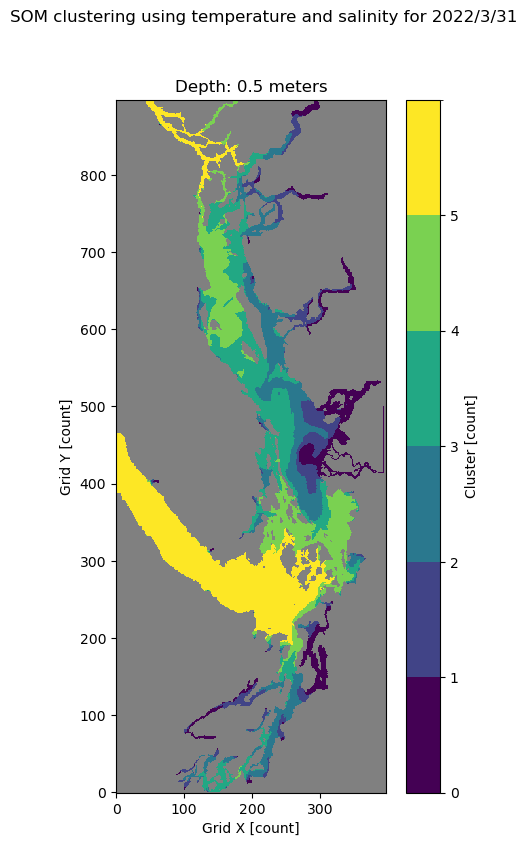

The amount of grid boxes for cluster 0 is 21977 

The minimum temperature for cluster 0 is 7.42 degrees Celsius
The maximum temperature for cluster 0 is 9.38 degrees Celsius
The mean temperature for cluster 0 is 7.96 degrees Celsius 

The minimum salinity for cluster 0 is 29.59 g/kg
The maximum salinity for cluster 0 is 31.32 g/kg
The mean salinity for cluster 0 is 30.56 g/kg 


The amount of grid boxes for cluster 1 is 12865 

The minimum temperature for cluster 1 is 6.72 degrees Celsius
The maximum temperature for cluster 1 is 9.72 degrees Celsius
The mean temperature for cluster 1 is 8.32 degrees Celsius 

The minimum salinity for cluster 1 is 28.17 g/kg
The maximum salinity for cluster 1 is 29.92 g/kg
The mean salinity for cluster 1 is 28.94 g/kg 


The amount of grid boxes for cluster 2 is 17568 

The minimum temperature for cluster 2 is 7.42 degrees Celsius
The maximum temperature for cluster 2 is 10.0 degrees Celsius
The mean temperature for cluster 2 is 8.69 degrees Celsius 

T

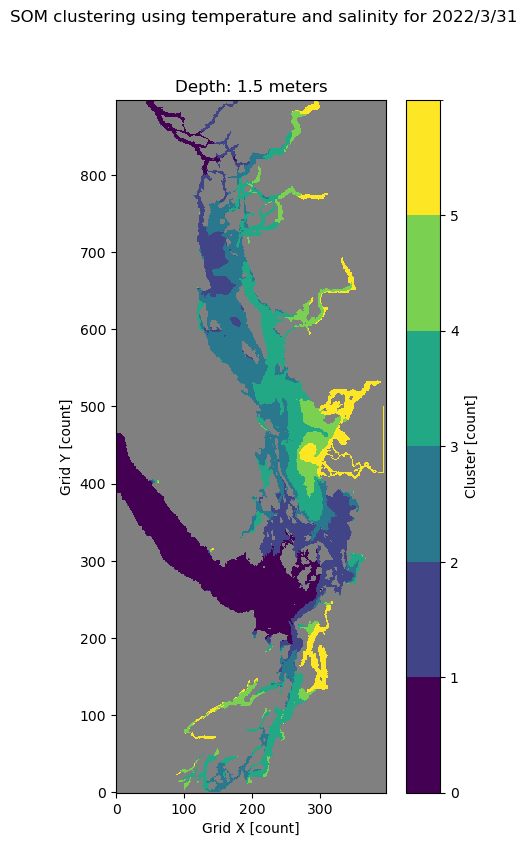

The amount of grid boxes for cluster 0 is 4012 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 11.12 degrees Celsius
The mean temperature for cluster 0 is 8.91 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 20.23 g/kg
The mean salinity for cluster 0 is 15.37 g/kg 


The amount of grid boxes for cluster 1 is 5501 

The minimum temperature for cluster 1 is 7.72 degrees Celsius
The maximum temperature for cluster 1 is 10.9 degrees Celsius
The mean temperature for cluster 1 is 9.14 degrees Celsius 

The minimum salinity for cluster 1 is 20.17 g/kg
The maximum salinity for cluster 1 is 23.93 g/kg
The mean salinity for cluster 1 is 22.09 g/kg 


The amount of grid boxes for cluster 2 is 11396 

The minimum temperature for cluster 2 is 7.59 degrees Celsius
The maximum temperature for cluster 2 is 10.52 degrees Celsius
The mean temperature for cluster 2 is 8.97 degrees Celsius 

The

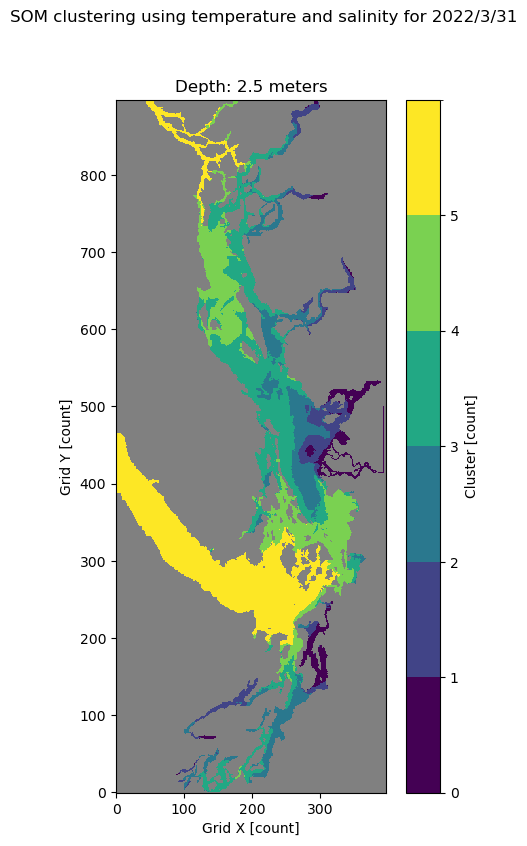

The amount of grid boxes for cluster 0 is 22157 

The minimum temperature for cluster 0 is 7.13 degrees Celsius
The maximum temperature for cluster 0 is 9.34 degrees Celsius
The mean temperature for cluster 0 is 7.95 degrees Celsius 

The minimum salinity for cluster 0 is 29.57 g/kg
The maximum salinity for cluster 0 is 31.33 g/kg
The mean salinity for cluster 0 is 30.57 g/kg 


The amount of grid boxes for cluster 1 is 11956 

The minimum temperature for cluster 1 is 6.71 degrees Celsius
The maximum temperature for cluster 1 is 9.65 degrees Celsius
The mean temperature for cluster 1 is 8.23 degrees Celsius 

The minimum salinity for cluster 1 is 28.47 g/kg
The maximum salinity for cluster 1 is 29.89 g/kg
The mean salinity for cluster 1 is 29.1 g/kg 


The amount of grid boxes for cluster 2 is 18114 

The minimum temperature for cluster 2 is 7.43 degrees Celsius
The maximum temperature for cluster 2 is 9.71 degrees Celsius
The mean temperature for cluster 2 is 8.42 degrees Celsius 

Th

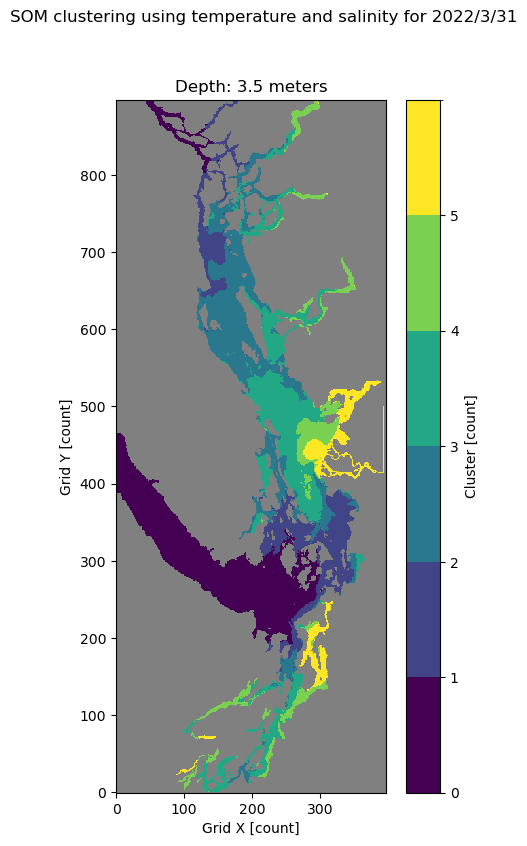

The amount of grid boxes for cluster 0 is 21171 

The minimum temperature for cluster 0 is 7.34 degrees Celsius
The maximum temperature for cluster 0 is 9.26 degrees Celsius
The mean temperature for cluster 0 is 7.93 degrees Celsius 

The minimum salinity for cluster 0 is 29.78 g/kg
The maximum salinity for cluster 0 is 31.36 g/kg
The mean salinity for cluster 0 is 30.62 g/kg 


The amount of grid boxes for cluster 1 is 11714 

The minimum temperature for cluster 1 is 6.67 degrees Celsius
The maximum temperature for cluster 1 is 9.36 degrees Celsius
The mean temperature for cluster 1 is 8.16 degrees Celsius 

The minimum salinity for cluster 1 is 28.69 g/kg
The maximum salinity for cluster 1 is 29.93 g/kg
The mean salinity for cluster 1 is 29.24 g/kg 


The amount of grid boxes for cluster 2 is 19644 

The minimum temperature for cluster 2 is 7.41 degrees Celsius
The maximum temperature for cluster 2 is 9.52 degrees Celsius
The mean temperature for cluster 2 is 8.3 degrees Celsius 

Th

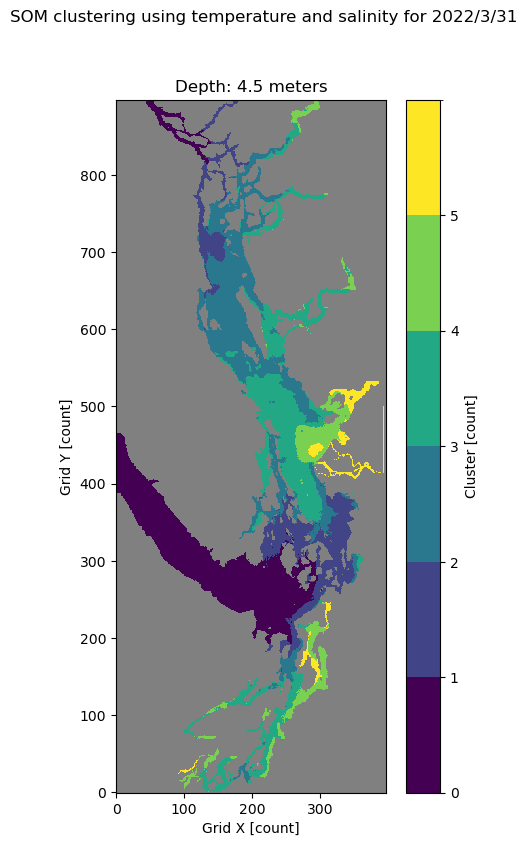

The amount of grid boxes for cluster 0 is 2318 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.47 degrees Celsius
The mean temperature for cluster 0 is 8.01 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 24.8 g/kg
The mean salinity for cluster 0 is 18.59 g/kg 


The amount of grid boxes for cluster 1 is 6144 

The minimum temperature for cluster 1 is 7.82 degrees Celsius
The maximum temperature for cluster 1 is 10.37 degrees Celsius
The mean temperature for cluster 1 is 8.84 degrees Celsius 

The minimum salinity for cluster 1 is 24.77 g/kg
The maximum salinity for cluster 1 is 27.2 g/kg
The mean salinity for cluster 1 is 26.14 g/kg 


The amount of grid boxes for cluster 2 is 17262 

The minimum temperature for cluster 2 is 7.31 degrees Celsius
The maximum temperature for cluster 2 is 10.35 degrees Celsius
The mean temperature for cluster 2 is 8.41 degrees Celsius 

The m

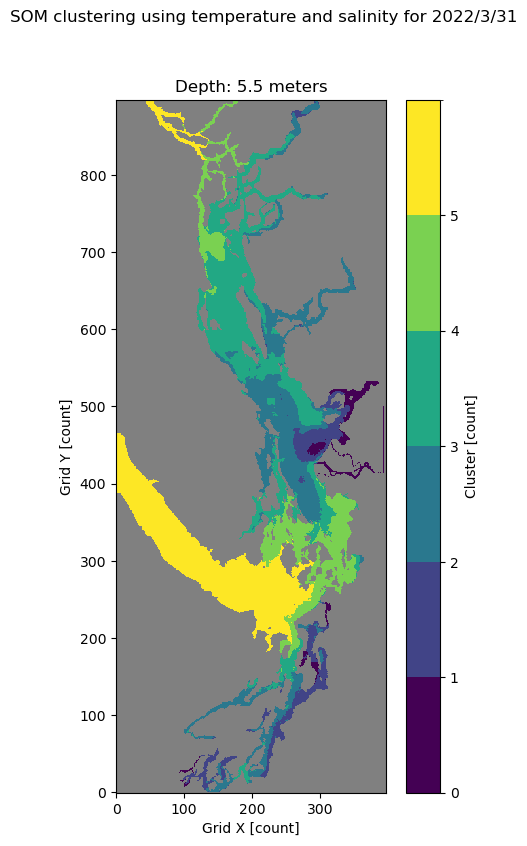

The amount of grid boxes for cluster 0 is 17223 

The minimum temperature for cluster 0 is 7.43 degrees Celsius
The maximum temperature for cluster 0 is 9.02 degrees Celsius
The mean temperature for cluster 0 is 7.9 degrees Celsius 

The minimum salinity for cluster 0 is 30.17 g/kg
The maximum salinity for cluster 0 is 31.42 g/kg
The mean salinity for cluster 0 is 30.78 g/kg 


The amount of grid boxes for cluster 1 is 8479 

The minimum temperature for cluster 1 is 6.32 degrees Celsius
The maximum temperature for cluster 1 is 9.04 degrees Celsius
The mean temperature for cluster 1 is 7.96 degrees Celsius 

The minimum salinity for cluster 1 is 29.3 g/kg
The maximum salinity for cluster 1 is 30.23 g/kg
The mean salinity for cluster 1 is 29.8 g/kg 


The amount of grid boxes for cluster 2 is 12180 

The minimum temperature for cluster 2 is 6.85 degrees Celsius
The maximum temperature for cluster 2 is 10.19 degrees Celsius
The mean temperature for cluster 2 is 8.21 degrees Celsius 

The 

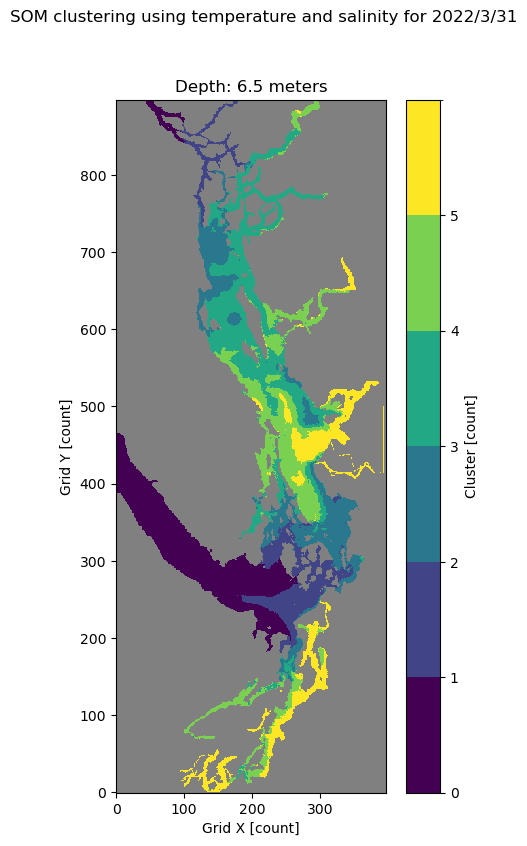

The amount of grid boxes for cluster 0 is 619 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.56 degrees Celsius
The mean temperature for cluster 0 is 7.35 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 25.32 g/kg
The mean salinity for cluster 0 is 9.01 g/kg 


The amount of grid boxes for cluster 1 is 7579 

The minimum temperature for cluster 1 is 7.31 degrees Celsius
The maximum temperature for cluster 1 is 9.7 degrees Celsius
The mean temperature for cluster 1 is 8.48 degrees Celsius 

The minimum salinity for cluster 1 is 25.32 g/kg
The maximum salinity for cluster 1 is 27.64 g/kg
The mean salinity for cluster 1 is 27.16 g/kg 


The amount of grid boxes for cluster 2 is 19050 

The minimum temperature for cluster 2 is 7.32 degrees Celsius
The maximum temperature for cluster 2 is 10.3 degrees Celsius
The mean temperature for cluster 2 is 8.22 degrees Celsius 

The mini

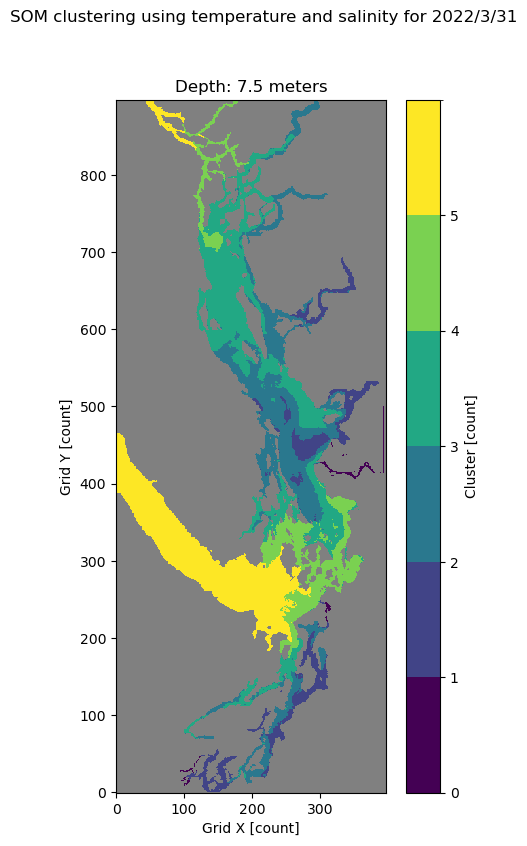

The amount of grid boxes for cluster 0 is 17422 

The minimum temperature for cluster 0 is 7.37 degrees Celsius
The maximum temperature for cluster 0 is 8.75 degrees Celsius
The mean temperature for cluster 0 is 7.88 degrees Celsius 

The minimum salinity for cluster 0 is 30.14 g/kg
The maximum salinity for cluster 0 is 31.46 g/kg
The mean salinity for cluster 0 is 30.8 g/kg 


The amount of grid boxes for cluster 1 is 10112 

The minimum temperature for cluster 1 is 6.15 degrees Celsius
The maximum temperature for cluster 1 is 8.77 degrees Celsius
The mean temperature for cluster 1 is 7.96 degrees Celsius 

The minimum salinity for cluster 1 is 29.27 g/kg
The maximum salinity for cluster 1 is 30.2 g/kg
The mean salinity for cluster 1 is 29.72 g/kg 


The amount of grid boxes for cluster 2 is 17820 

The minimum temperature for cluster 2 is 7.5 degrees Celsius
The maximum temperature for cluster 2 is 10.19 degrees Celsius
The mean temperature for cluster 2 is 8.16 degrees Celsius 

The

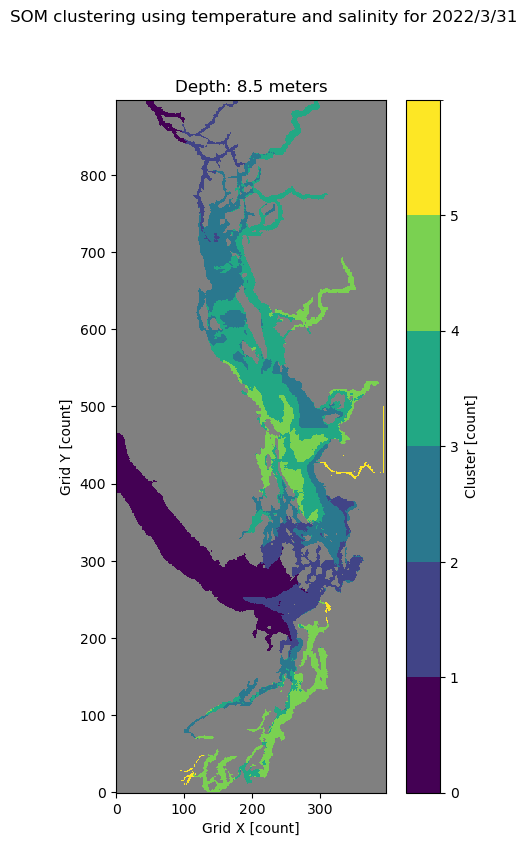

The amount of grid boxes for cluster 0 is 2981 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.29 degrees Celsius
The mean temperature for cluster 0 is 8.44 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.85 g/kg
The mean salinity for cluster 0 is 24.41 g/kg 


The amount of grid boxes for cluster 1 is 12421 

The minimum temperature for cluster 1 is 7.65 degrees Celsius
The maximum temperature for cluster 1 is 10.27 degrees Celsius
The mean temperature for cluster 1 is 8.53 degrees Celsius 

The minimum salinity for cluster 1 is 27.7 g/kg
The maximum salinity for cluster 1 is 29.16 g/kg
The mean salinity for cluster 1 is 28.14 g/kg 


The amount of grid boxes for cluster 2 is 22652 

The minimum temperature for cluster 2 is 7.39 degrees Celsius
The maximum temperature for cluster 2 is 8.62 degrees Celsius
The mean temperature for cluster 2 is 7.94 degrees Celsius 

The 

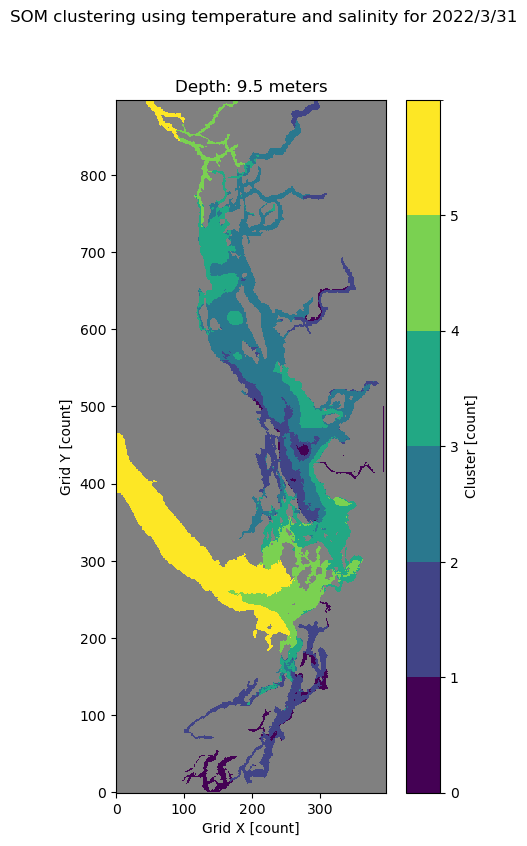

The amount of grid boxes for cluster 0 is 443 

The minimum temperature for cluster 0 is 6.38 degrees Celsius
The maximum temperature for cluster 0 is 9.19 degrees Celsius
The mean temperature for cluster 0 is 7.78 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 26.64 g/kg
The mean salinity for cluster 0 is 14.51 g/kg 


The amount of grid boxes for cluster 1 is 10482 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 10.34 degrees Celsius
The mean temperature for cluster 1 is 8.38 degrees Celsius 

The minimum salinity for cluster 1 is 26.62 g/kg
The maximum salinity for cluster 1 is 28.37 g/kg
The mean salinity for cluster 1 is 27.96 g/kg 


The amount of grid boxes for cluster 2 is 22371 

The minimum temperature for cluster 2 is 7.38 degrees Celsius
The maximum temperature for cluster 2 is 10.25 degrees Celsius
The mean temperature for cluster 2 is 8.05 degrees Celsius 

The

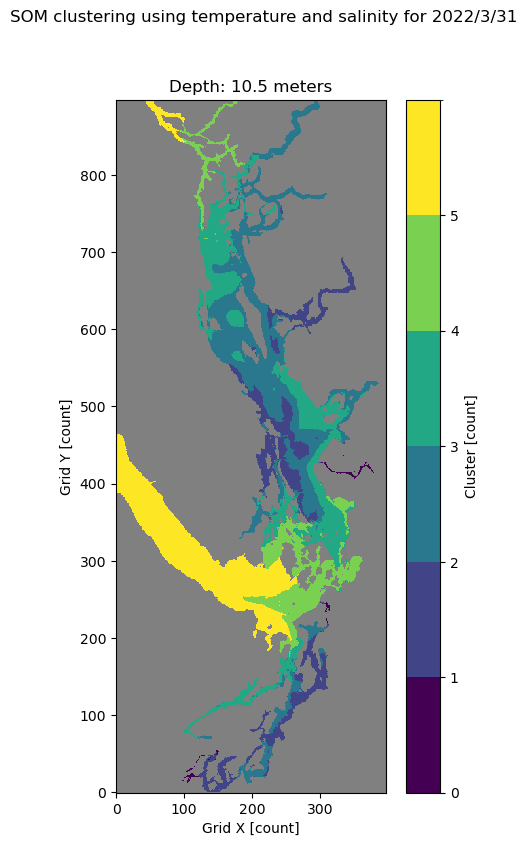

The amount of grid boxes for cluster 0 is 338 

The minimum temperature for cluster 0 is 6.41 degrees Celsius
The maximum temperature for cluster 0 is 9.17 degrees Celsius
The mean temperature for cluster 0 is 7.62 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 26.52 g/kg
The mean salinity for cluster 0 is 12.76 g/kg 


The amount of grid boxes for cluster 1 is 9781 

The minimum temperature for cluster 1 is 7.62 degrees Celsius
The maximum temperature for cluster 1 is 10.43 degrees Celsius
The mean temperature for cluster 1 is 8.46 degrees Celsius 

The minimum salinity for cluster 1 is 26.52 g/kg
The maximum salinity for cluster 1 is 28.67 g/kg
The mean salinity for cluster 1 is 28.06 g/kg 


The amount of grid boxes for cluster 2 is 19337 

The minimum temperature for cluster 2 is 7.37 degrees Celsius
The maximum temperature for cluster 2 is 10.22 degrees Celsius
The mean temperature for cluster 2 is 8.06 degrees Celsius 

The 

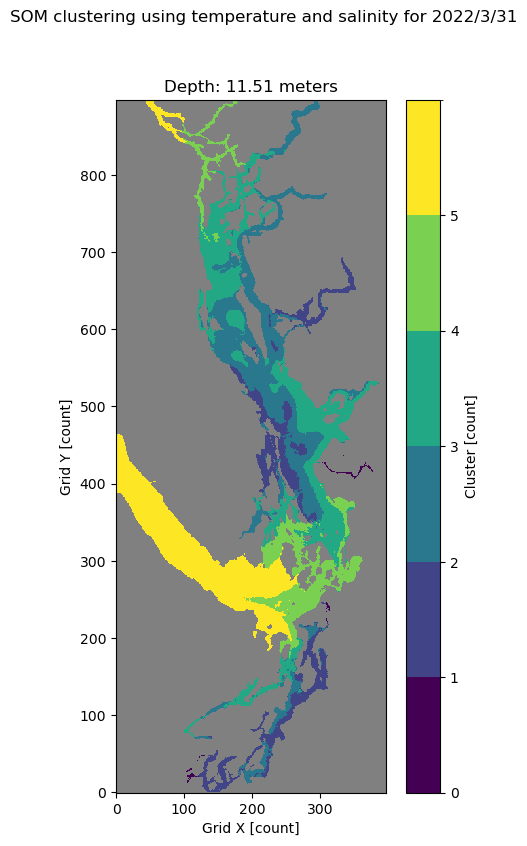

The amount of grid boxes for cluster 0 is 16252 

The minimum temperature for cluster 0 is 7.26 degrees Celsius
The maximum temperature for cluster 0 is 8.33 degrees Celsius
The mean temperature for cluster 0 is 7.84 degrees Celsius 

The minimum salinity for cluster 0 is 30.33 g/kg
The maximum salinity for cluster 0 is 31.64 g/kg
The mean salinity for cluster 0 is 30.89 g/kg 


The amount of grid boxes for cluster 1 is 7219 

The minimum temperature for cluster 1 is 6.45 degrees Celsius
The maximum temperature for cluster 1 is 8.65 degrees Celsius
The mean temperature for cluster 1 is 7.89 degrees Celsius 

The minimum salinity for cluster 1 is 29.58 g/kg
The maximum salinity for cluster 1 is 30.37 g/kg
The mean salinity for cluster 1 is 29.97 g/kg 


The amount of grid boxes for cluster 2 is 14920 

The minimum temperature for cluster 2 is 7.54 degrees Celsius
The maximum temperature for cluster 2 is 8.66 degrees Celsius
The mean temperature for cluster 2 is 8.12 degrees Celsius 

Th

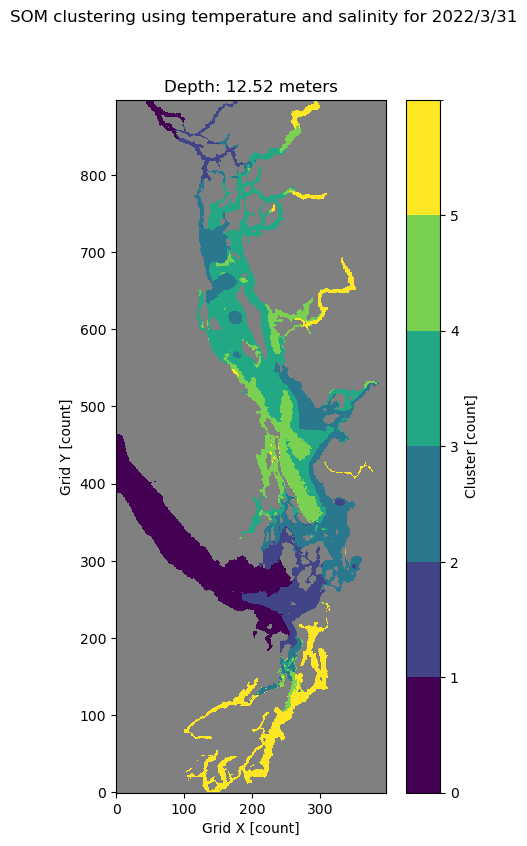

The amount of grid boxes for cluster 0 is 16520 

The minimum temperature for cluster 0 is 7.24 degrees Celsius
The maximum temperature for cluster 0 is 8.32 degrees Celsius
The mean temperature for cluster 0 is 7.83 degrees Celsius 

The minimum salinity for cluster 0 is 30.24 g/kg
The maximum salinity for cluster 0 is 31.68 g/kg
The mean salinity for cluster 0 is 30.89 g/kg 


The amount of grid boxes for cluster 1 is 9177 

The minimum temperature for cluster 1 is 6.56 degrees Celsius
The maximum temperature for cluster 1 is 8.65 degrees Celsius
The mean temperature for cluster 1 is 7.91 degrees Celsius 

The minimum salinity for cluster 1 is 29.4 g/kg
The maximum salinity for cluster 1 is 30.34 g/kg
The mean salinity for cluster 1 is 29.85 g/kg 


The amount of grid boxes for cluster 2 is 18803 

The minimum temperature for cluster 2 is 7.71 degrees Celsius
The maximum temperature for cluster 2 is 10.53 degrees Celsius
The mean temperature for cluster 2 is 8.33 degrees Celsius 

Th

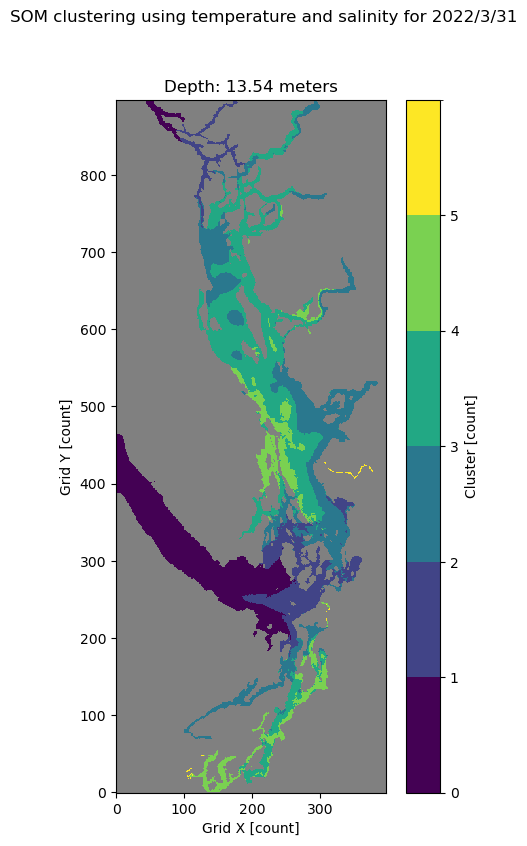

The amount of grid boxes for cluster 0 is 21575 

The minimum temperature for cluster 0 is 7.37 degrees Celsius
The maximum temperature for cluster 0 is 8.17 degrees Celsius
The mean temperature for cluster 0 is 7.91 degrees Celsius 

The minimum salinity for cluster 0 is 28.03 g/kg
The maximum salinity for cluster 0 is 29.13 g/kg
The mean salinity for cluster 0 is 28.74 g/kg 


The amount of grid boxes for cluster 1 is 9162 

The minimum temperature for cluster 1 is 6.42 degrees Celsius
The maximum temperature for cluster 1 is 9.31 degrees Celsius
The mean temperature for cluster 1 is 8.39 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 29.03 g/kg
The mean salinity for cluster 1 is 28.1 g/kg 


The amount of grid boxes for cluster 2 is 6059 

The minimum temperature for cluster 2 is 8.21 degrees Celsius
The maximum temperature for cluster 2 is 10.54 degrees Celsius
The mean temperature for cluster 2 is 8.95 degrees Celsius 

The m

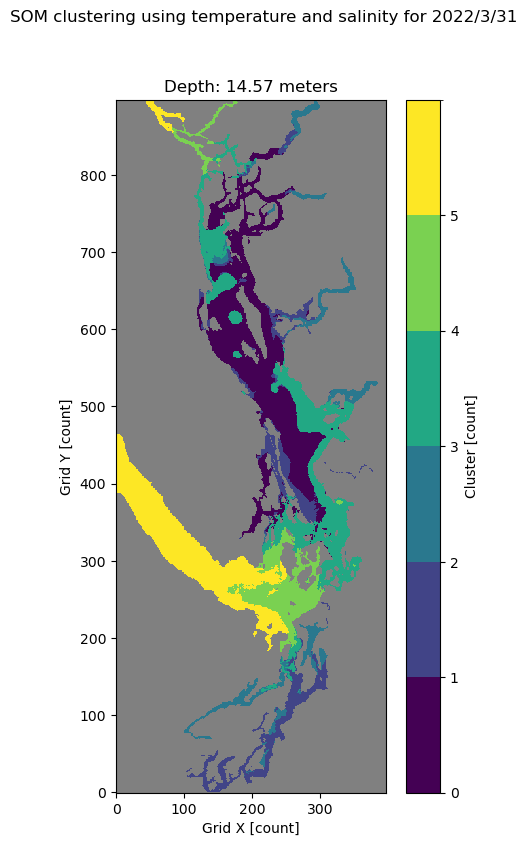

The amount of grid boxes for cluster 0 is 17437 

The minimum temperature for cluster 0 is 6.42 degrees Celsius
The maximum temperature for cluster 0 is 8.11 degrees Celsius
The mean temperature for cluster 0 is 7.88 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.08 g/kg
The mean salinity for cluster 0 is 28.64 g/kg 


The amount of grid boxes for cluster 1 is 7642 

The minimum temperature for cluster 1 is 8.1 degrees Celsius
The maximum temperature for cluster 1 is 10.21 degrees Celsius
The mean temperature for cluster 1 is 8.49 degrees Celsius 

The minimum salinity for cluster 1 is 20.07 g/kg
The maximum salinity for cluster 1 is 28.85 g/kg
The mean salinity for cluster 1 is 28.37 g/kg 


The amount of grid boxes for cluster 2 is 15854 

The minimum temperature for cluster 2 is 7.9 degrees Celsius
The maximum temperature for cluster 2 is 10.53 degrees Celsius
The mean temperature for cluster 2 is 8.45 degrees Celsius 

The 

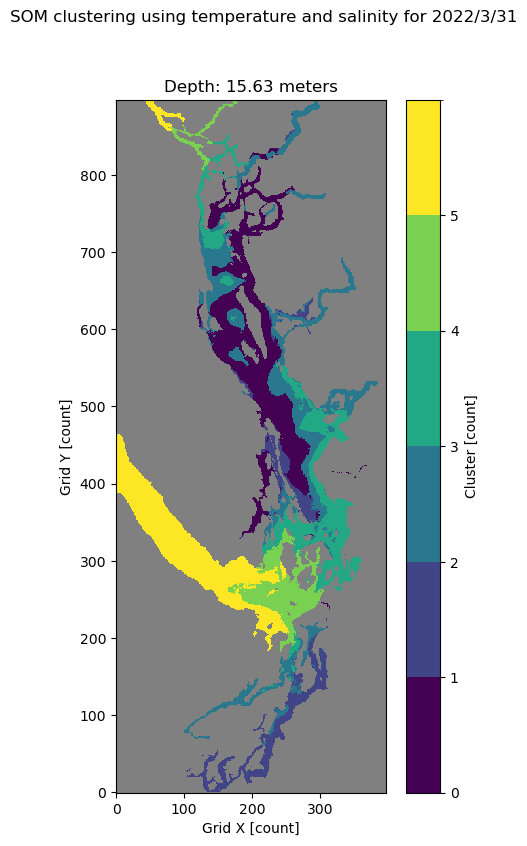

The amount of grid boxes for cluster 0 is 6920 

The minimum temperature for cluster 0 is 8.45 degrees Celsius
The maximum temperature for cluster 0 is 10.49 degrees Celsius
The mean temperature for cluster 0 is 9.04 degrees Celsius 

The minimum salinity for cluster 0 is 28.06 g/kg
The maximum salinity for cluster 0 is 29.64 g/kg
The mean salinity for cluster 0 is 28.96 g/kg 


The amount of grid boxes for cluster 1 is 5491 

The minimum temperature for cluster 1 is 6.48 degrees Celsius
The maximum temperature for cluster 1 is 9.14 degrees Celsius
The mean temperature for cluster 1 is 8.31 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 29.06 g/kg
The mean salinity for cluster 1 is 28.15 g/kg 


The amount of grid boxes for cluster 2 is 20414 

The minimum temperature for cluster 2 is 7.35 degrees Celsius
The maximum temperature for cluster 2 is 8.4 degrees Celsius
The mean temperature for cluster 2 is 7.93 degrees Celsius 

The m

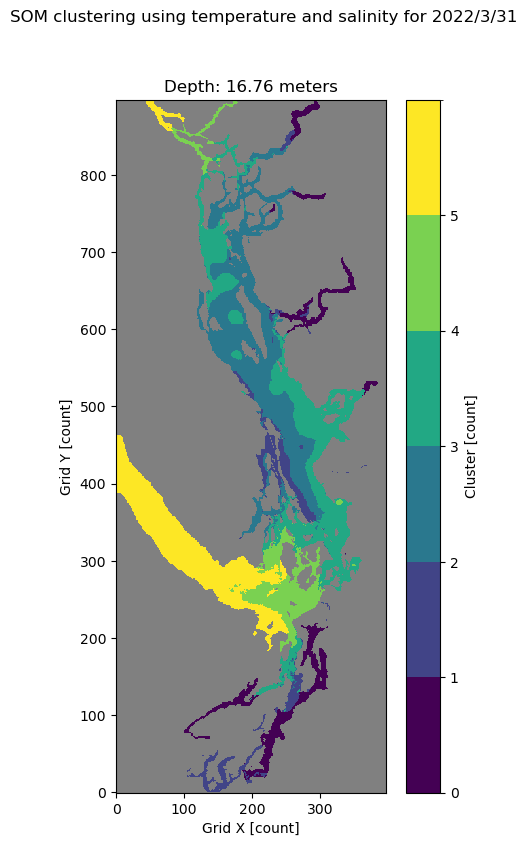

The amount of grid boxes for cluster 0 is 16636 

The minimum temperature for cluster 0 is 6.48 degrees Celsius
The maximum temperature for cluster 0 is 9.13 degrees Celsius
The mean temperature for cluster 0 is 7.95 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.14 g/kg
The mean salinity for cluster 0 is 28.66 g/kg 


The amount of grid boxes for cluster 1 is 12409 

The minimum temperature for cluster 1 is 7.82 degrees Celsius
The maximum temperature for cluster 1 is 9.31 degrees Celsius
The mean temperature for cluster 1 is 8.19 degrees Celsius 

The minimum salinity for cluster 1 is 28.07 g/kg
The maximum salinity for cluster 1 is 29.26 g/kg
The mean salinity for cluster 1 is 28.98 g/kg 


The amount of grid boxes for cluster 2 is 13361 

The minimum temperature for cluster 2 is 8.06 degrees Celsius
The maximum temperature for cluster 2 is 10.42 degrees Celsius
The mean temperature for cluster 2 is 8.66 degrees Celsius 

Th

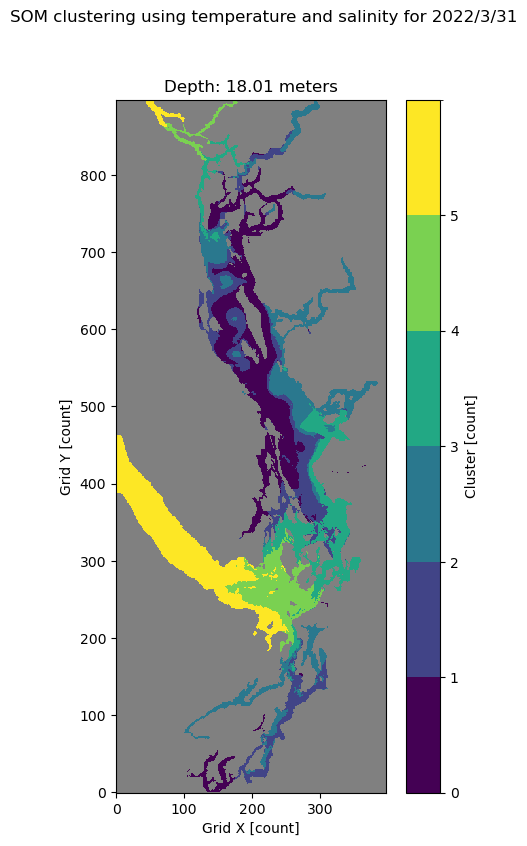

The amount of grid boxes for cluster 0 is 12143 

The minimum temperature for cluster 0 is 7.15 degrees Celsius
The maximum temperature for cluster 0 is 8.18 degrees Celsius
The mean temperature for cluster 0 is 7.76 degrees Celsius 

The minimum salinity for cluster 0 is 30.7 g/kg
The maximum salinity for cluster 0 is 31.97 g/kg
The mean salinity for cluster 0 is 31.12 g/kg 


The amount of grid boxes for cluster 1 is 7255 

The minimum temperature for cluster 1 is 7.17 degrees Celsius
The maximum temperature for cluster 1 is 8.06 degrees Celsius
The mean temperature for cluster 1 is 7.82 degrees Celsius 

The minimum salinity for cluster 1 is 29.89 g/kg
The maximum salinity for cluster 1 is 30.76 g/kg
The mean salinity for cluster 1 is 30.4 g/kg 


The amount of grid boxes for cluster 2 is 10796 

The minimum temperature for cluster 2 is 7.58 degrees Celsius
The maximum temperature for cluster 2 is 8.67 degrees Celsius
The mean temperature for cluster 2 is 7.99 degrees Celsius 

The 

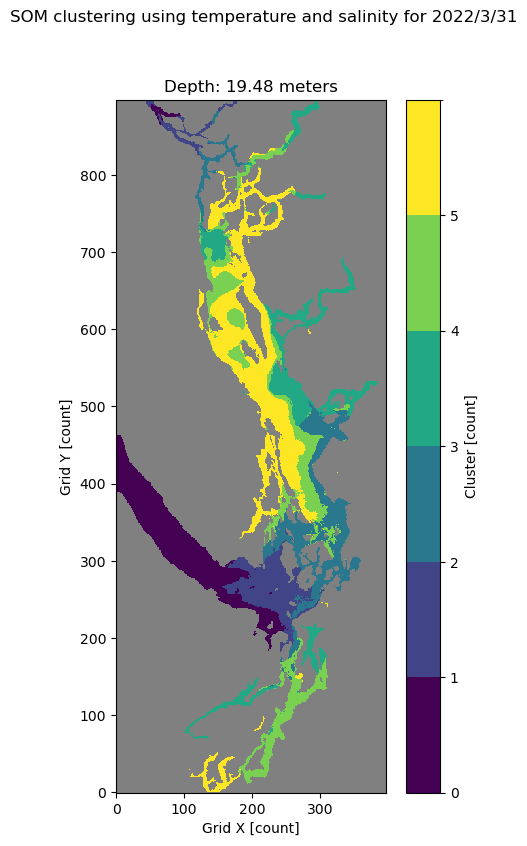

The amount of grid boxes for cluster 0 is 9762 

The minimum temperature for cluster 0 is 8.35 degrees Celsius
The maximum temperature for cluster 0 is 10.23 degrees Celsius
The mean temperature for cluster 0 is 8.9 degrees Celsius 

The minimum salinity for cluster 0 is 28.73 g/kg
The maximum salinity for cluster 0 is 29.9 g/kg
The mean salinity for cluster 0 is 29.34 g/kg 


The amount of grid boxes for cluster 1 is 6251 

The minimum temperature for cluster 1 is 7.93 degrees Celsius
The maximum temperature for cluster 1 is 9.04 degrees Celsius
The mean temperature for cluster 1 is 8.36 degrees Celsius 

The minimum salinity for cluster 1 is 23.37 g/kg
The maximum salinity for cluster 1 is 29.28 g/kg
The mean salinity for cluster 1 is 28.65 g/kg 


The amount of grid boxes for cluster 2 is 19261 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 8.23 degrees Celsius
The mean temperature for cluster 2 is 7.97 degrees Celsius 

The 

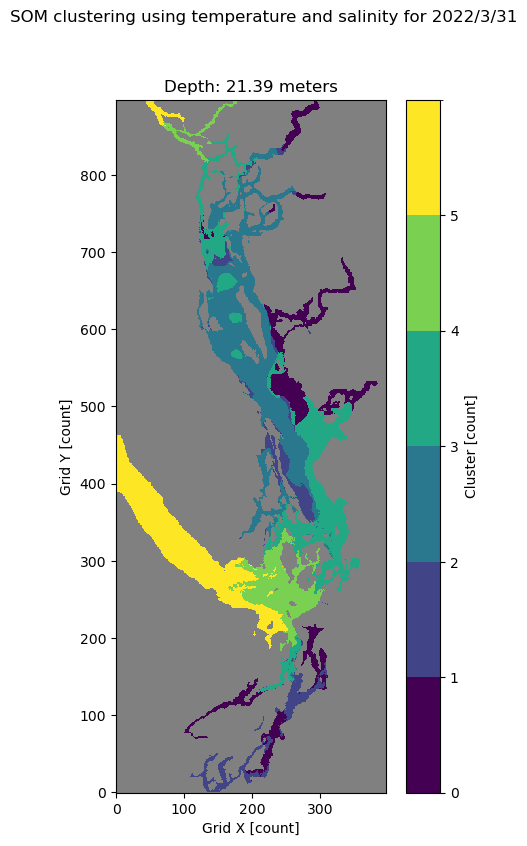

The amount of grid boxes for cluster 0 is 14117 

The minimum temperature for cluster 0 is 7.13 degrees Celsius
The maximum temperature for cluster 0 is 8.13 degrees Celsius
The mean temperature for cluster 0 is 7.72 degrees Celsius 

The minimum salinity for cluster 0 is 30.54 g/kg
The maximum salinity for cluster 0 is 32.22 g/kg
The mean salinity for cluster 0 is 31.14 g/kg 


The amount of grid boxes for cluster 1 is 6414 

The minimum temperature for cluster 1 is 7.28 degrees Celsius
The maximum temperature for cluster 1 is 8.28 degrees Celsius
The mean temperature for cluster 1 is 7.85 degrees Celsius 

The minimum salinity for cluster 1 is 29.85 g/kg
The maximum salinity for cluster 1 is 30.69 g/kg
The mean salinity for cluster 1 is 30.25 g/kg 


The amount of grid boxes for cluster 2 is 8300 

The minimum temperature for cluster 2 is 8.25 degrees Celsius
The maximum temperature for cluster 2 is 10.2 degrees Celsius
The mean temperature for cluster 2 is 8.97 degrees Celsius 

The

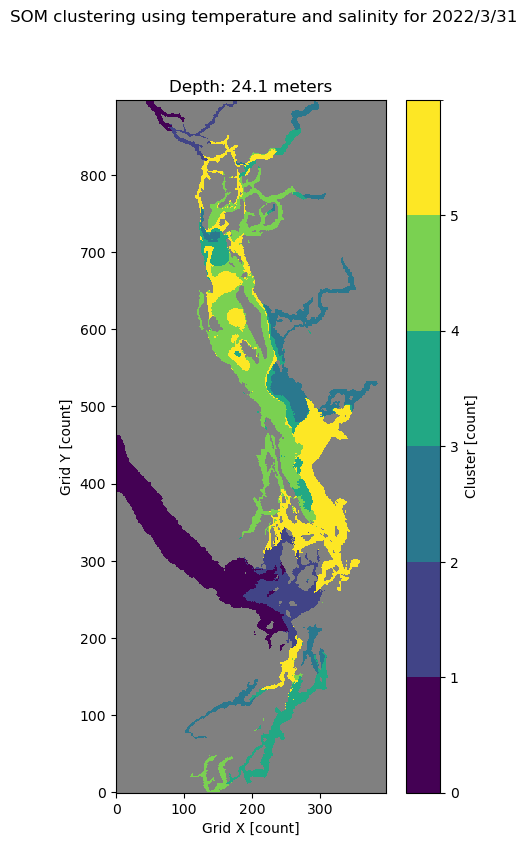

The amount of grid boxes for cluster 0 is 9356 

The minimum temperature for cluster 0 is 8.36 degrees Celsius
The maximum temperature for cluster 0 is 10.21 degrees Celsius
The mean temperature for cluster 0 is 8.94 degrees Celsius 

The minimum salinity for cluster 0 is 28.78 g/kg
The maximum salinity for cluster 0 is 30.25 g/kg
The mean salinity for cluster 0 is 29.63 g/kg 


The amount of grid boxes for cluster 1 is 9377 

The minimum temperature for cluster 1 is 8.23 degrees Celsius
The maximum temperature for cluster 1 is 8.8 degrees Celsius
The mean temperature for cluster 1 is 8.39 degrees Celsius 

The minimum salinity for cluster 1 is 26.61 g/kg
The maximum salinity for cluster 1 is 29.63 g/kg
The mean salinity for cluster 1 is 29.1 g/kg 


The amount of grid boxes for cluster 2 is 19196 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 8.23 degrees Celsius
The mean temperature for cluster 2 is 8.06 degrees Celsius 

The 

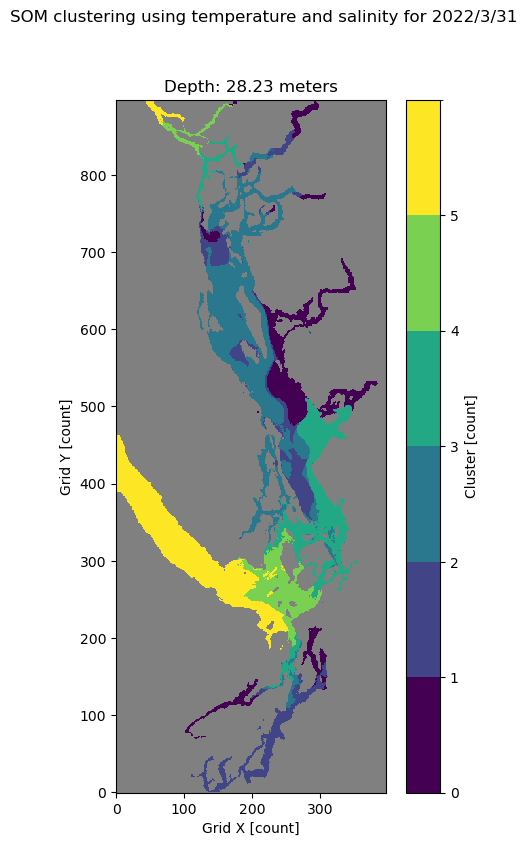

The amount of grid boxes for cluster 0 is 12536 

The minimum temperature for cluster 0 is 7.13 degrees Celsius
The maximum temperature for cluster 0 is 7.87 degrees Celsius
The mean temperature for cluster 0 is 7.63 degrees Celsius 

The minimum salinity for cluster 0 is 30.78 g/kg
The maximum salinity for cluster 0 is 32.62 g/kg
The mean salinity for cluster 0 is 31.42 g/kg 


The amount of grid boxes for cluster 1 is 6164 

The minimum temperature for cluster 1 is 7.32 degrees Celsius
The maximum temperature for cluster 1 is 8.56 degrees Celsius
The mean temperature for cluster 1 is 7.78 degrees Celsius 

The minimum salinity for cluster 1 is 29.99 g/kg
The maximum salinity for cluster 1 is 30.86 g/kg
The mean salinity for cluster 1 is 30.48 g/kg 


The amount of grid boxes for cluster 2 is 11164 

The minimum temperature for cluster 2 is 7.58 degrees Celsius
The maximum temperature for cluster 2 is 8.42 degrees Celsius
The mean temperature for cluster 2 is 8.0 degrees Celsius 

The

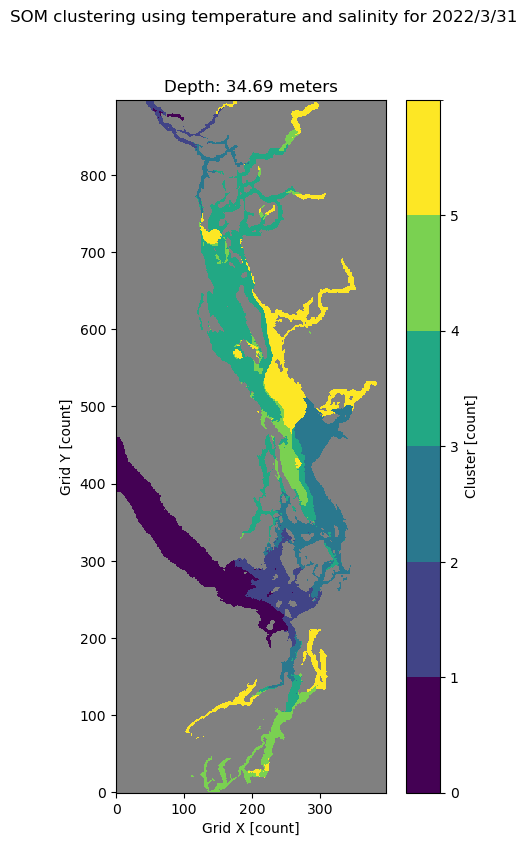

The amount of grid boxes for cluster 0 is 11860 

The minimum temperature for cluster 0 is 7.37 degrees Celsius
The maximum temperature for cluster 0 is 7.78 degrees Celsius
The mean temperature for cluster 0 is 7.56 degrees Celsius 

The minimum salinity for cluster 0 is 31.09 g/kg
The maximum salinity for cluster 0 is 32.93 g/kg
The mean salinity for cluster 0 is 31.7 g/kg 


The amount of grid boxes for cluster 1 is 5728 

The minimum temperature for cluster 1 is 7.13 degrees Celsius
The maximum temperature for cluster 1 is 7.96 degrees Celsius
The mean temperature for cluster 1 is 7.73 degrees Celsius 

The minimum salinity for cluster 1 is 30.08 g/kg
The maximum salinity for cluster 1 is 31.12 g/kg
The mean salinity for cluster 1 is 30.66 g/kg 


The amount of grid boxes for cluster 2 is 11274 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 8.41 degrees Celsius
The mean temperature for cluster 2 is 7.97 degrees Celsius 

The

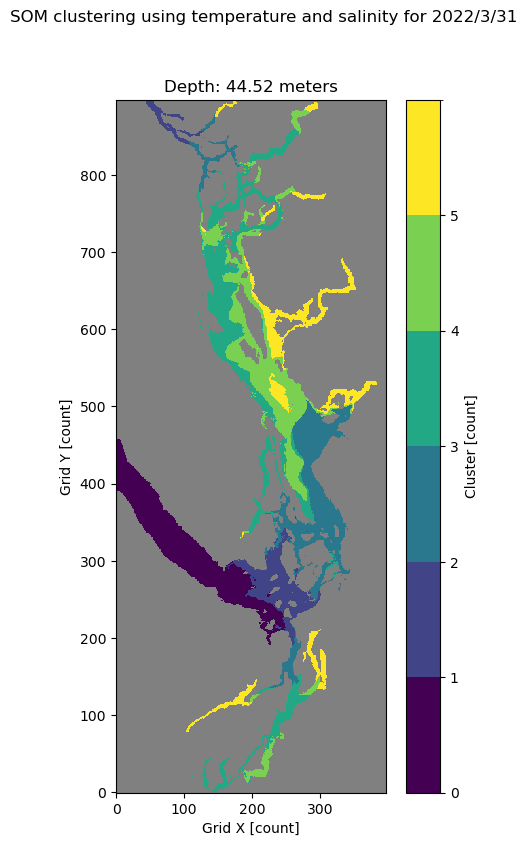

The amount of grid boxes for cluster 0 is 9855 

The minimum temperature for cluster 0 is 8.48 degrees Celsius
The maximum temperature for cluster 0 is 10.39 degrees Celsius
The mean temperature for cluster 0 is 8.98 degrees Celsius 

The minimum salinity for cluster 0 is 29.58 g/kg
The maximum salinity for cluster 0 is 30.47 g/kg
The mean salinity for cluster 0 is 30.0 g/kg 


The amount of grid boxes for cluster 1 is 15326 

The minimum temperature for cluster 1 is 8.33 degrees Celsius
The maximum temperature for cluster 1 is 8.75 degrees Celsius
The mean temperature for cluster 1 is 8.49 degrees Celsius 

The minimum salinity for cluster 1 is 27.44 g/kg
The maximum salinity for cluster 1 is 30.3 g/kg
The mean salinity for cluster 1 is 29.7 g/kg 


The amount of grid boxes for cluster 2 is 12362 

The minimum temperature for cluster 2 is 7.62 degrees Celsius
The maximum temperature for cluster 2 is 8.36 degrees Celsius
The mean temperature for cluster 2 is 8.09 degrees Celsius 

The 

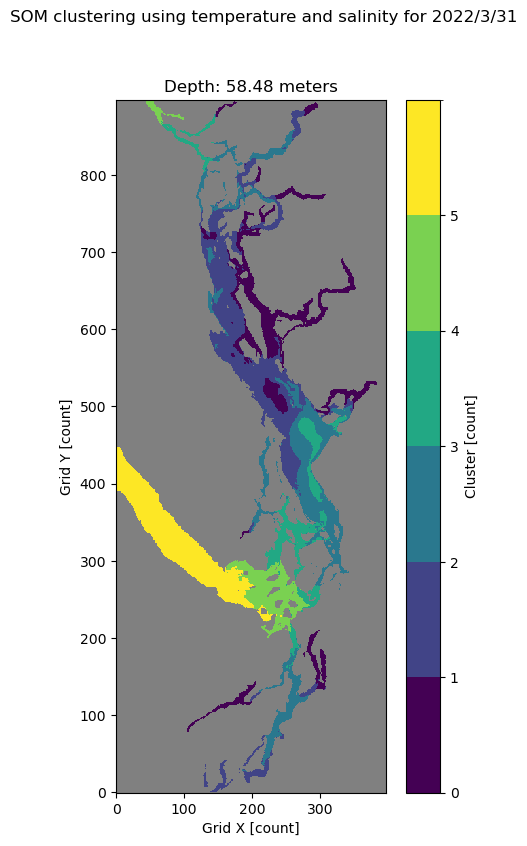

The amount of grid boxes for cluster 0 is 14569 

The minimum temperature for cluster 0 is 7.43 degrees Celsius
The maximum temperature for cluster 0 is 8.62 degrees Celsius
The mean temperature for cluster 0 is 7.96 degrees Celsius 

The minimum salinity for cluster 0 is 27.51 g/kg
The maximum salinity for cluster 0 is 30.65 g/kg
The mean salinity for cluster 0 is 29.92 g/kg 


The amount of grid boxes for cluster 1 is 11496 

The minimum temperature for cluster 1 is 8.24 degrees Celsius
The maximum temperature for cluster 1 is 8.79 degrees Celsius
The mean temperature for cluster 1 is 8.5 degrees Celsius 

The minimum salinity for cluster 1 is 28.35 g/kg
The maximum salinity for cluster 1 is 30.2 g/kg
The mean salinity for cluster 1 is 29.92 g/kg 


The amount of grid boxes for cluster 2 is 12288 

The minimum temperature for cluster 2 is 8.61 degrees Celsius
The maximum temperature for cluster 2 is 10.45 degrees Celsius
The mean temperature for cluster 2 is 8.94 degrees Celsius 

Th

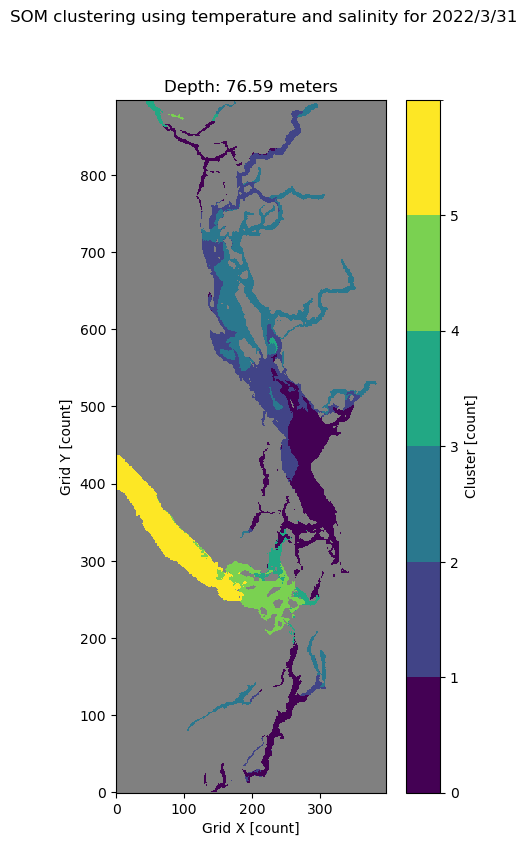

The amount of grid boxes for cluster 0 is 13302 

The minimum temperature for cluster 0 is 8.67 degrees Celsius
The maximum temperature for cluster 0 is 10.48 degrees Celsius
The mean temperature for cluster 0 is 8.99 degrees Celsius 

The minimum salinity for cluster 0 is 29.63 g/kg
The maximum salinity for cluster 0 is 30.57 g/kg
The mean salinity for cluster 0 is 30.22 g/kg 


The amount of grid boxes for cluster 1 is 5796 

The minimum temperature for cluster 1 is 8.24 degrees Celsius
The maximum temperature for cluster 1 is 8.78 degrees Celsius
The mean temperature for cluster 1 is 8.52 degrees Celsius 

The minimum salinity for cluster 1 is 27.53 g/kg
The maximum salinity for cluster 1 is 30.39 g/kg
The mean salinity for cluster 1 is 30.03 g/kg 


The amount of grid boxes for cluster 2 is 14445 

The minimum temperature for cluster 2 is 7.5 degrees Celsius
The maximum temperature for cluster 2 is 8.28 degrees Celsius
The mean temperature for cluster 2 is 7.97 degrees Celsius 

Th

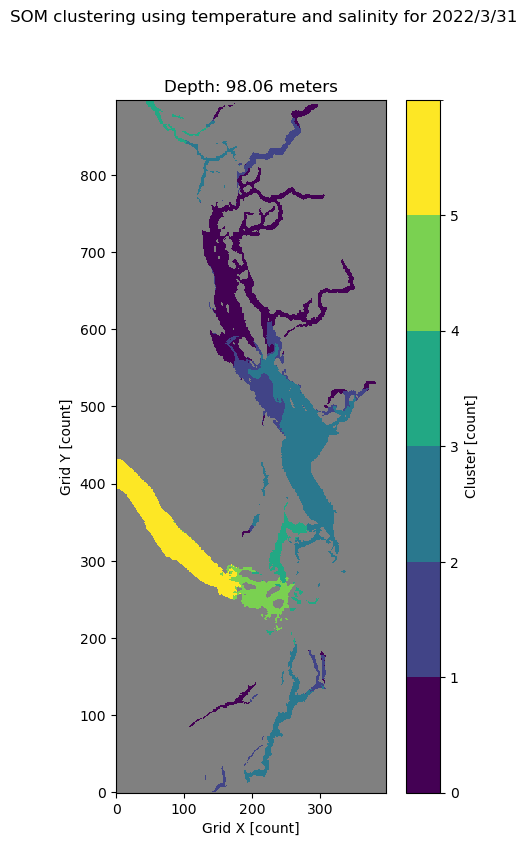

The amount of grid boxes for cluster 0 is 7150 

The minimum temperature for cluster 0 is 6.94 degrees Celsius
The maximum temperature for cluster 0 is 7.3 degrees Celsius
The mean temperature for cluster 0 is 7.13 degrees Celsius 

The minimum salinity for cluster 0 is 32.82 g/kg
The maximum salinity for cluster 0 is 33.68 g/kg
The mean salinity for cluster 0 is 33.4 g/kg 


The amount of grid boxes for cluster 1 is 1762 

The minimum temperature for cluster 1 is 7.27 degrees Celsius
The maximum temperature for cluster 1 is 7.6 degrees Celsius
The mean temperature for cluster 1 is 7.41 degrees Celsius 

The minimum salinity for cluster 1 is 31.51 g/kg
The maximum salinity for cluster 1 is 32.82 g/kg
The mean salinity for cluster 1 is 32.14 g/kg 


The amount of grid boxes for cluster 2 is 1492 

The minimum temperature for cluster 2 is 7.29 degrees Celsius
The maximum temperature for cluster 2 is 7.89 degrees Celsius
The mean temperature for cluster 2 is 7.64 degrees Celsius 

The min

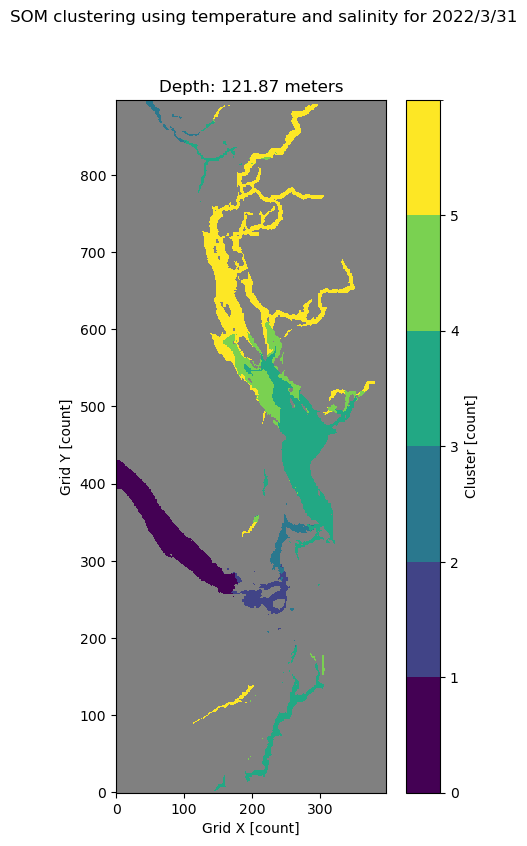

The amount of grid boxes for cluster 0 is 9858 

The minimum temperature for cluster 0 is 8.93 degrees Celsius
The maximum temperature for cluster 0 is 10.78 degrees Celsius
The mean temperature for cluster 0 is 9.16 degrees Celsius 

The minimum salinity for cluster 0 is 29.87 g/kg
The maximum salinity for cluster 0 is 30.87 g/kg
The mean salinity for cluster 0 is 30.55 g/kg 


The amount of grid boxes for cluster 1 is 4389 

The minimum temperature for cluster 1 is 8.43 degrees Celsius
The maximum temperature for cluster 1 is 9.02 degrees Celsius
The mean temperature for cluster 1 is 8.73 degrees Celsius 

The minimum salinity for cluster 1 is 29.81 g/kg
The maximum salinity for cluster 1 is 30.72 g/kg
The mean salinity for cluster 1 is 30.52 g/kg 


The amount of grid boxes for cluster 2 is 6374 

The minimum temperature for cluster 2 is 7.71 degrees Celsius
The maximum temperature for cluster 2 is 8.56 degrees Celsius
The mean temperature for cluster 2 is 8.1 degrees Celsius 

The 

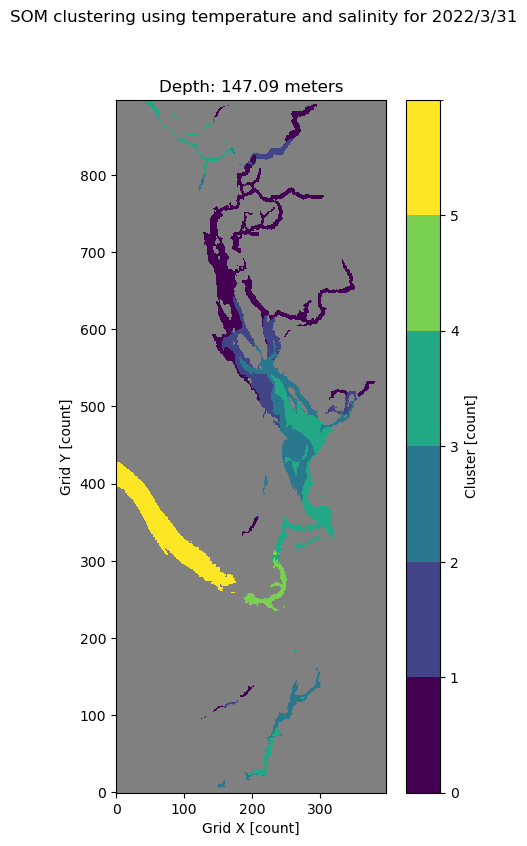

The amount of grid boxes for cluster 0 is 4442 

The minimum temperature for cluster 0 is 6.72 degrees Celsius
The maximum temperature for cluster 0 is 7.23 degrees Celsius
The mean temperature for cluster 0 is 6.99 degrees Celsius 

The minimum salinity for cluster 0 is 33.07 g/kg
The maximum salinity for cluster 0 is 33.84 g/kg
The mean salinity for cluster 0 is 33.63 g/kg 


The amount of grid boxes for cluster 1 is 794 

The minimum temperature for cluster 1 is 7.31 degrees Celsius
The maximum temperature for cluster 1 is 7.68 degrees Celsius
The mean temperature for cluster 1 is 7.55 degrees Celsius 

The minimum salinity for cluster 1 is 31.03 g/kg
The maximum salinity for cluster 1 is 32.33 g/kg
The mean salinity for cluster 1 is 31.48 g/kg 


The amount of grid boxes for cluster 2 is 6118 

The minimum temperature for cluster 2 is 7.38 degrees Celsius
The maximum temperature for cluster 2 is 8.54 degrees Celsius
The mean temperature for cluster 2 is 7.92 degrees Celsius 

The m

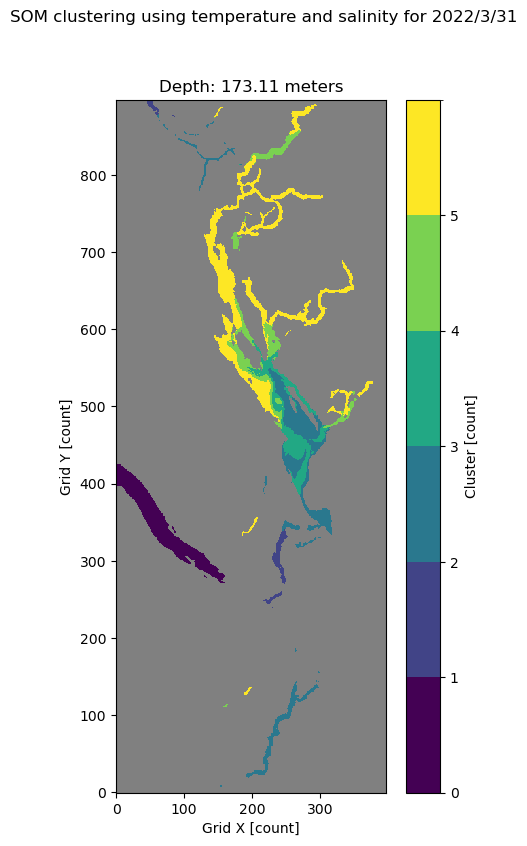

The amount of grid boxes for cluster 0 is 6448 

The minimum temperature for cluster 0 is 9.09 degrees Celsius
The maximum temperature for cluster 0 is 9.92 degrees Celsius
The mean temperature for cluster 0 is 9.27 degrees Celsius 

The minimum salinity for cluster 0 is 30.34 g/kg
The maximum salinity for cluster 0 is 31.0 g/kg
The mean salinity for cluster 0 is 30.79 g/kg 


The amount of grid boxes for cluster 1 is 5121 

The minimum temperature for cluster 1 is 8.73 degrees Celsius
The maximum temperature for cluster 1 is 9.28 degrees Celsius
The mean temperature for cluster 1 is 9.02 degrees Celsius 

The minimum salinity for cluster 1 is 30.15 g/kg
The maximum salinity for cluster 1 is 30.91 g/kg
The mean salinity for cluster 1 is 30.67 g/kg 


The amount of grid boxes for cluster 2 is 2815 

The minimum temperature for cluster 2 is 8.23 degrees Celsius
The maximum temperature for cluster 2 is 8.76 degrees Celsius
The mean temperature for cluster 2 is 8.41 degrees Celsius 

The m

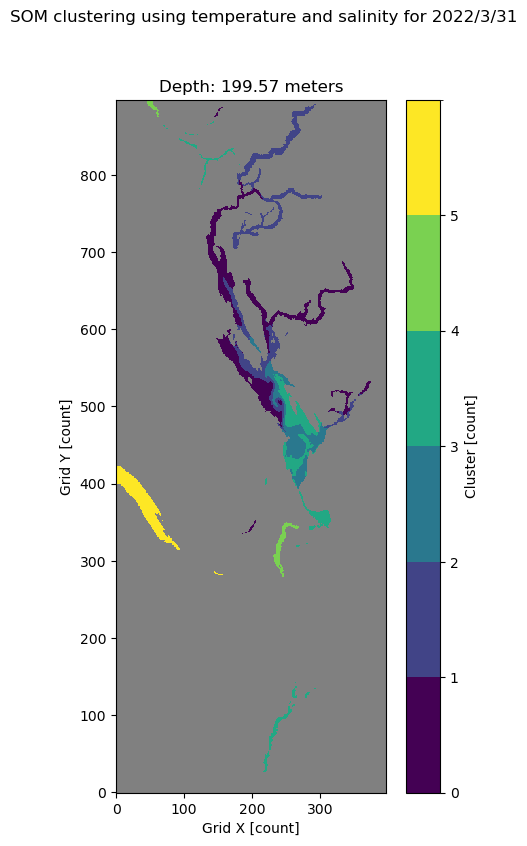

The amount of grid boxes for cluster 0 is 6319 

The minimum temperature for cluster 0 is 9.06 degrees Celsius
The maximum temperature for cluster 0 is 9.92 degrees Celsius
The mean temperature for cluster 0 is 9.3 degrees Celsius 

The minimum salinity for cluster 0 is 30.36 g/kg
The maximum salinity for cluster 0 is 31.04 g/kg
The mean salinity for cluster 0 is 30.9 g/kg 


The amount of grid boxes for cluster 1 is 3974 

The minimum temperature for cluster 1 is 8.87 degrees Celsius
The maximum temperature for cluster 1 is 9.28 degrees Celsius
The mean temperature for cluster 1 is 9.06 degrees Celsius 

The minimum salinity for cluster 1 is 30.16 g/kg
The maximum salinity for cluster 1 is 30.96 g/kg
The mean salinity for cluster 1 is 30.68 g/kg 


The amount of grid boxes for cluster 2 is 1694 

The minimum temperature for cluster 2 is 8.49 degrees Celsius
The maximum temperature for cluster 2 is 8.89 degrees Celsius
The mean temperature for cluster 2 is 8.66 degrees Celsius 

The mi

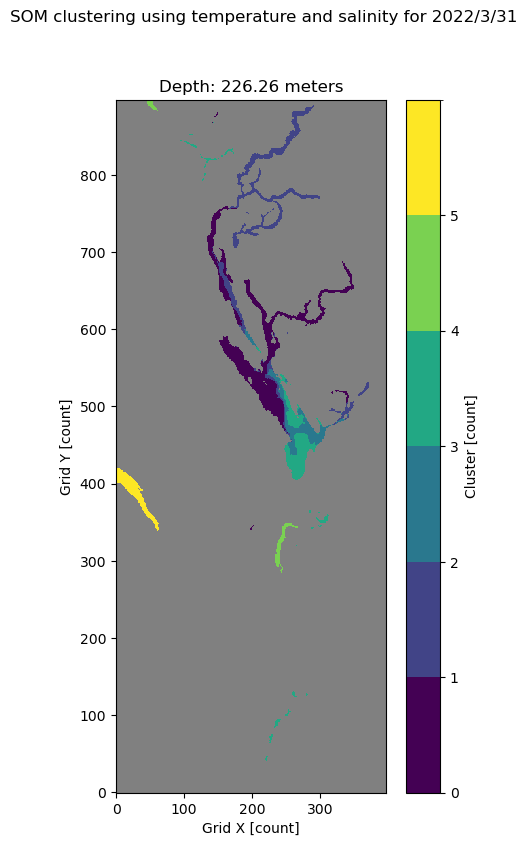

The amount of grid boxes for cluster 0 is 344 

The minimum temperature for cluster 0 is 6.43 degrees Celsius
The maximum temperature for cluster 0 is 6.91 degrees Celsius
The mean temperature for cluster 0 is 6.57 degrees Celsius 

The minimum salinity for cluster 0 is 33.75 g/kg
The maximum salinity for cluster 0 is 33.96 g/kg
The mean salinity for cluster 0 is 33.9 g/kg 


The amount of grid boxes for cluster 1 is 362 

The minimum temperature for cluster 1 is 7.44 degrees Celsius
The maximum temperature for cluster 1 is 7.75 degrees Celsius
The mean temperature for cluster 1 is 7.6 degrees Celsius 

The minimum salinity for cluster 1 is 30.12 g/kg
The maximum salinity for cluster 1 is 31.81 g/kg
The mean salinity for cluster 1 is 31.19 g/kg 


The amount of grid boxes for cluster 2 is 2116 

The minimum temperature for cluster 2 is 7.65 degrees Celsius
The maximum temperature for cluster 2 is 8.87 degrees Celsius
The mean temperature for cluster 2 is 8.54 degrees Celsius 

The mini

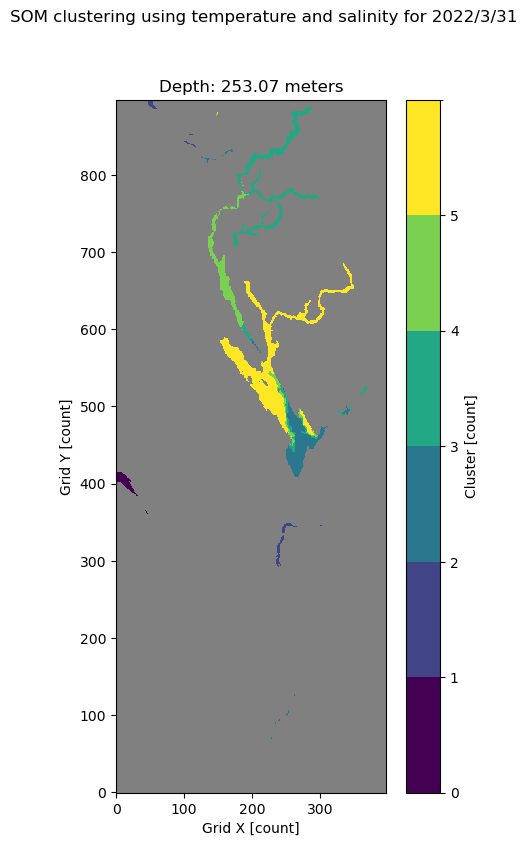

The amount of grid boxes for cluster 0 is 3582 

The minimum temperature for cluster 0 is 9.29 degrees Celsius
The maximum temperature for cluster 0 is 9.42 degrees Celsius
The mean temperature for cluster 0 is 9.38 degrees Celsius 

The minimum salinity for cluster 0 is 31.01 g/kg
The maximum salinity for cluster 0 is 31.11 g/kg
The mean salinity for cluster 0 is 31.07 g/kg 


The amount of grid boxes for cluster 1 is 1739 

The minimum temperature for cluster 1 is 9.06 degrees Celsius
The maximum temperature for cluster 1 is 9.39 degrees Celsius
The mean temperature for cluster 1 is 9.24 degrees Celsius 

The minimum salinity for cluster 1 is 30.83 g/kg
The maximum salinity for cluster 1 is 31.09 g/kg
The mean salinity for cluster 1 is 31.04 g/kg 


The amount of grid boxes for cluster 2 is 1315 

The minimum temperature for cluster 2 is 8.96 degrees Celsius
The maximum temperature for cluster 2 is 9.39 degrees Celsius
The mean temperature for cluster 2 is 9.25 degrees Celsius 

The 

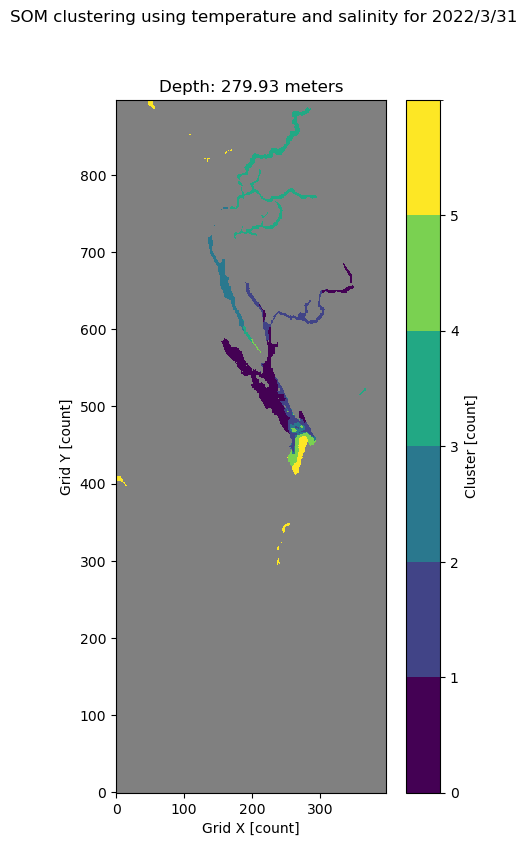

The amount of grid boxes for cluster 0 is 3499 

The minimum temperature for cluster 0 is 9.31 degrees Celsius
The maximum temperature for cluster 0 is 9.44 degrees Celsius
The mean temperature for cluster 0 is 9.4 degrees Celsius 

The minimum salinity for cluster 0 is 31.05 g/kg
The maximum salinity for cluster 0 is 31.14 g/kg
The mean salinity for cluster 0 is 31.1 g/kg 


The amount of grid boxes for cluster 1 is 1563 

The minimum temperature for cluster 1 is 9.06 degrees Celsius
The maximum temperature for cluster 1 is 9.4 degrees Celsius
The mean temperature for cluster 1 is 9.27 degrees Celsius 

The minimum salinity for cluster 1 is 30.84 g/kg
The maximum salinity for cluster 1 is 31.11 g/kg
The mean salinity for cluster 1 is 31.05 g/kg 


The amount of grid boxes for cluster 2 is 606 

The minimum temperature for cluster 2 is 9.03 degrees Celsius
The maximum temperature for cluster 2 is 9.4 degrees Celsius
The mean temperature for cluster 2 is 9.32 degrees Celsius 

The minim

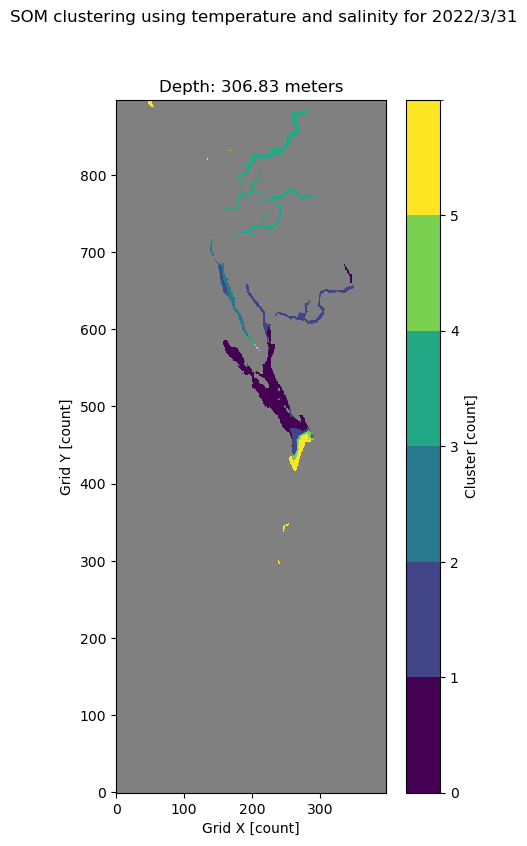

The amount of grid boxes for cluster 0 is 2884 

The minimum temperature for cluster 0 is 9.36 degrees Celsius
The maximum temperature for cluster 0 is 9.45 degrees Celsius
The mean temperature for cluster 0 is 9.42 degrees Celsius 

The minimum salinity for cluster 0 is 31.09 g/kg
The maximum salinity for cluster 0 is 31.17 g/kg
The mean salinity for cluster 0 is 31.13 g/kg 


The amount of grid boxes for cluster 1 is 670 

The minimum temperature for cluster 1 is 9.25 degrees Celsius
The maximum temperature for cluster 1 is 9.4 degrees Celsius
The mean temperature for cluster 1 is 9.33 degrees Celsius 

The minimum salinity for cluster 1 is 31.05 g/kg
The maximum salinity for cluster 1 is 31.14 g/kg
The mean salinity for cluster 1 is 31.1 g/kg 


The amount of grid boxes for cluster 2 is 847 

The minimum temperature for cluster 2 is 9.05 degrees Celsius
The maximum temperature for cluster 2 is 9.4 degrees Celsius
The mean temperature for cluster 2 is 9.29 degrees Celsius 

The minim

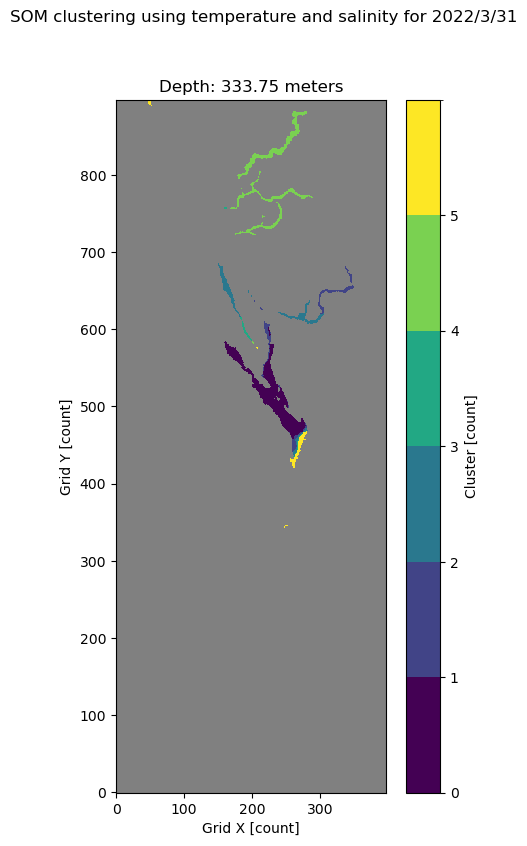

The amount of grid boxes for cluster 0 is 769 

The minimum temperature for cluster 0 is 8.93 degrees Celsius
The maximum temperature for cluster 0 is 9.02 degrees Celsius
The mean temperature for cluster 0 is 8.98 degrees Celsius 

The minimum salinity for cluster 0 is 30.67 g/kg
The maximum salinity for cluster 0 is 30.72 g/kg
The mean salinity for cluster 0 is 30.7 g/kg 


The amount of grid boxes for cluster 1 is 872 

The minimum temperature for cluster 1 is 9.01 degrees Celsius
The maximum temperature for cluster 1 is 9.09 degrees Celsius
The mean temperature for cluster 1 is 9.04 degrees Celsius 

The minimum salinity for cluster 1 is 30.71 g/kg
The maximum salinity for cluster 1 is 30.76 g/kg
The mean salinity for cluster 1 is 30.74 g/kg 


The amount of grid boxes for cluster 2 is 53 

The minimum temperature for cluster 2 is 8.9 degrees Celsius
The maximum temperature for cluster 2 is 9.39 degrees Celsius
The mean temperature for cluster 2 is 9.26 degrees Celsius 

The minimu

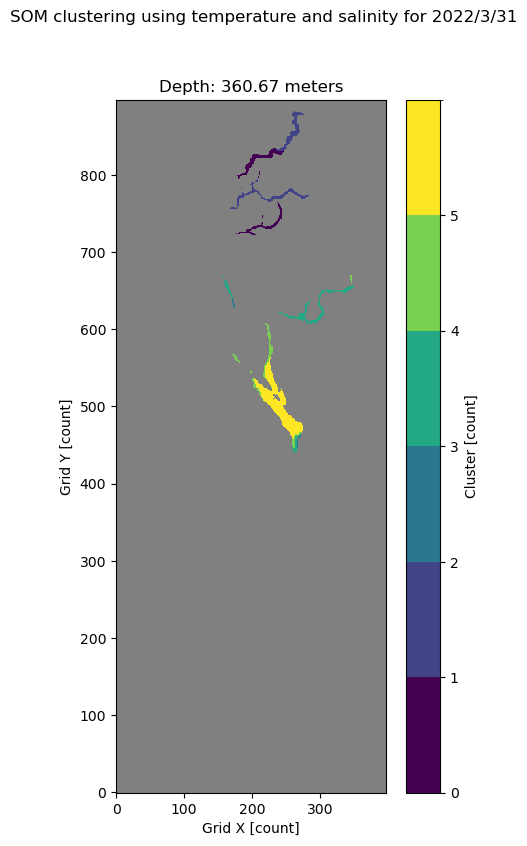

The amount of grid boxes for cluster 0 is 1474 

The minimum temperature for cluster 0 is 9.42 degrees Celsius
The maximum temperature for cluster 0 is 9.45 degrees Celsius
The mean temperature for cluster 0 is 9.44 degrees Celsius 

The minimum salinity for cluster 0 is 31.13 g/kg
The maximum salinity for cluster 0 is 31.18 g/kg
The mean salinity for cluster 0 is 31.16 g/kg 


The amount of grid boxes for cluster 1 is 101 

The minimum temperature for cluster 1 is 9.34 degrees Celsius
The maximum temperature for cluster 1 is 9.42 degrees Celsius
The mean temperature for cluster 1 is 9.4 degrees Celsius 

The minimum salinity for cluster 1 is 31.09 g/kg
The maximum salinity for cluster 1 is 31.15 g/kg
The mean salinity for cluster 1 is 31.12 g/kg 


The amount of grid boxes for cluster 2 is 491 

The minimum temperature for cluster 2 is 9.2 degrees Celsius
The maximum temperature for cluster 2 is 9.33 degrees Celsius
The mean temperature for cluster 2 is 9.25 degrees Celsius 

The mini

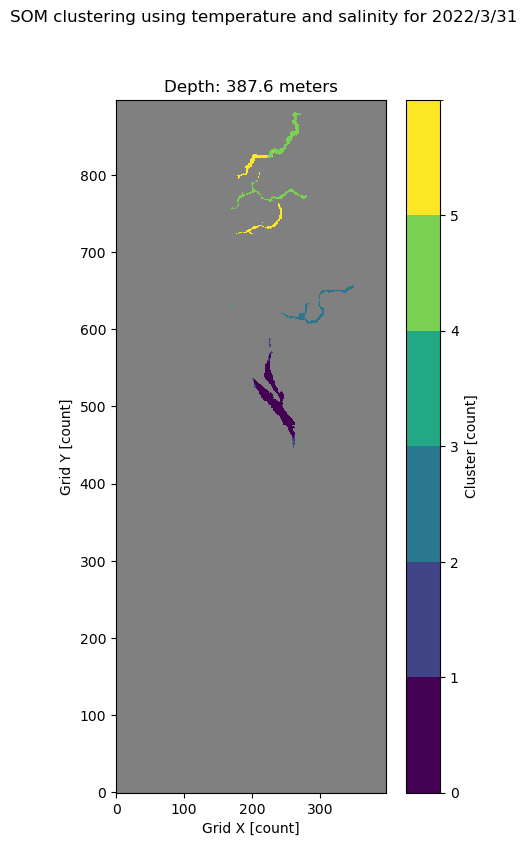

The amount of grid boxes for cluster 0 is 507 

The minimum temperature for cluster 0 is 8.92 degrees Celsius
The maximum temperature for cluster 0 is 9.02 degrees Celsius
The mean temperature for cluster 0 is 8.97 degrees Celsius 

The minimum salinity for cluster 0 is 30.68 g/kg
The maximum salinity for cluster 0 is 30.73 g/kg
The mean salinity for cluster 0 is 30.71 g/kg 


The amount of grid boxes for cluster 1 is 724 

The minimum temperature for cluster 1 is 9.02 degrees Celsius
The maximum temperature for cluster 1 is 9.08 degrees Celsius
The mean temperature for cluster 1 is 9.04 degrees Celsius 

The minimum salinity for cluster 1 is 30.72 g/kg
The maximum salinity for cluster 1 is 30.77 g/kg
The mean salinity for cluster 1 is 30.75 g/kg 


The amount of grid boxes for cluster 3 is 68 

The minimum temperature for cluster 3 is 9.2 degrees Celsius
The maximum temperature for cluster 3 is 9.3 degrees Celsius
The mean temperature for cluster 3 is 9.24 degrees Celsius 

The minimu

IndexError: index 5 is out of bounds for axis 0 with size 5

In [8]:
ds, temp, saline, date, mask = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline = masking(depth, temp, saline, mask)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique)


In [ ]:
unique.size

9